In this notebook we will generate features from the trained tokenizer and train a very simple neural network to classify the sequences.

The aim is to demonstrate the exposed in the paper, but feel free to try more complex models, linear models, decission trees... Depending on your use case as for example raw precission or interpretability you may use one model or another. The features generated by the tokenizer work in all of them. 

Also I am running this on my laptop so do not worry about compute power, there is no need.

## DEPENDENCIES

In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm

import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing as mp
import itertools

from tokenizers import SentencePieceBPETokenizer, ByteLevelBPETokenizer

from utils import tokenize_worker, make_plot, top10_accuracy_scorer

from sklearn import metrics

## DATA

In [2]:
train = pd.read_csv('../data/raw/train_values.csv')
test = pd.read_csv('../data/raw/test_values.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')
print('Train: ',train.shape)
print('Train labels: ',train_labels.shape)
print('Test: ',test.shape)

Train:  (63017, 41)
Train labels:  (63017, 1315)
Test:  (18816, 41)


In [3]:
# We create a dictionary laboratoy -> ID
# We assing to each laboratory an id, which is its index in the columns labels
labs = train_labels.columns[1:].values

lab_pos = dict()
i = 0
for lab in labs:
    lab_pos[lab]=i
    i+=1

In [4]:
# Train and train labels are in the same order
train_labels.drop(['sequence_id'],axis=1,inplace = True)
train['target'] = train_labels.idxmax(axis='columns')
train.shape

(63017, 42)

## FEATURE ENGINEERING

In [5]:
# Add a column with sequences lenght
train['seq_len'] = train.sequence.apply(lambda x: len(x))
test['seq_len'] = test.sequence.apply(lambda x: len(x))

In [6]:
# Load tokenizer and get count of tokens in the vocabulary for each sequence

path = "../data/tokenizer/SP_2500/"

#tokenizer = ByteLevelBPETokenizer(str(path+'vocab.json'),str(path+'merges.txt'))
tokenizer = SentencePieceBPETokenizer(str(path+'vocab.json'),str(path+'merges.txt'),dropout=0.01, unk_token='<unk>')

vocab_size = 2500

do_multiprocessing = False # MP ERROR WITH IPYTHON CURRENT VERSION, WORKS WITH PYTHON

def get_seq_embeddings(df):

    embeddings = []
    ids = []

    if do_multiprocessing:
        pool = mp.Pool(mp.cpu_count())
        with tqdm(total=df.shape[0]) as pbar:
            # seq, seq_id, vocab_size, tokenizer
            for i, row in enumerate(pool.imap_unordered(tokenize_worker, zip(df.sequence.values,df.sequence_id.values,itertools.repeat(vocab_size),itertools.repeat(tokenizer)))):
                embeddings.append(row[0])
                ids.append(row[1])
                pbar.update(1)
        pool.close()
        pool.join()
    else:
        with tqdm(total=df.shape[0]) as pbar:
            for row in zip(df.sequence.values,df.sequence_id.values,itertools.repeat(vocab_size),itertools.repeat(tokenizer)):
                row = tokenize_worker(row)
                embeddings.append(row[0])
                ids.append(row[1])
                pbar.update(1)

    df = pd.DataFrame(embeddings,dtype=np.int16)
    df['sequence_id'] = ids
    print(df.shape)

    return df

In [7]:
train_emb = get_seq_embeddings(train)
test_emb = get_seq_embeddings(test)


(63017, 2501)



(18816, 2501)


In [8]:
## Scale features, good if you are going to use a neural network, for Decision Tres or classifiersis may not be good

scaler = RobustScaler()
df = pd.concat([train_emb,test_emb],axis=0)
scaler.fit(df.iloc[:,:-1])


df = pd.DataFrame(scaler.transform(train_emb.iloc[:,:-1]))
df['sequence_id'] = train_emb['sequence_id']
train_emb = df

df = pd.DataFrame(scaler.transform(test_emb.iloc[:,:-1]))
df['sequence_id'] = test_emb['sequence_id']
test_emb = df

In [9]:
train = pd.merge(train,train_emb,how='inner',on='sequence_id')
test = pd.merge(test,test_emb,how='inner',on='sequence_id')

train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

print(train.shape)
print(test.shape)

(63017, 2543)
(18816, 2542)


## SPLIT DATA

In [10]:
train.drop(['sequence','sequence_id'],inplace=True,axis=1)
test.drop(['sequence_id','sequence'],inplace=True,axis=1)

In [11]:
X = train.drop('target',inplace=False,axis=1)
y = train['target']

In [12]:
# For best results use KFold and Stratified, but now for simplicity and showing the aim of the paper we will not use it.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=420)

## CREATE DATALOADERS

In [13]:
# FROM LAB TO ONE HOT
def get_targets(y):
    targets = []
    for lab in y:
        tmp = np.zeros(len(labs))
        idx = lab_pos[lab]
        tmp[idx] = 1
        targets.append(tmp)
    targets = torch.tensor(targets)
    return targets

In [14]:
%%time
tmp = [torch.from_numpy(arr).float() for arr in X_train.values]
train_dataset = torch.utils.data.TensorDataset(torch.stack(tmp),get_targets(y_train))
tmp = [torch.from_numpy(arr).float() for arr in X_valid.values]
valid_dataset = torch.utils.data.TensorDataset(torch.stack(tmp),get_targets(y_valid))
tmp = [torch.from_numpy(arr).float() for arr in test.values]
test_dataset = torch.utils.data.TensorDataset(torch.stack(tmp))

Wall time: 13.8 s


In [15]:
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset, 
    batch_size = 256, 
    sampler = torch.utils.data.RandomSampler(train_dataset)
)

In [16]:
valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset, 
    batch_size = 256, 
    sampler = torch.utils.data.SequentialSampler(valid_dataset)
)

In [17]:
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset, 
    batch_size = 256, 
    sampler = torch.utils.data.SequentialSampler(test_dataset)
)

## MODEL

In [18]:
# Simple nn of just one linear layer
# The input are the tabular data and the embeddings created by the tokenizer

# You can perfectly try more complex models and even linear models or decission trees, this depends on what you want to achieve and your use case

class TokeNet(nn.Module):

    def __init__(self):

        super().__init__()

        self.folder = '../artifacts/'

        self.input_shape = 2500 + 40
        self.out_shape = 1314

        self.hidden_size = self.input_shape 

        self.cls = nn.Linear(self.hidden_size,self.out_shape)
        
    def forward(self,batch, device):

        x = batch[0].to(device)
       
        x = self.cls(x)
        
        return x.cpu().float()

## TRAINING

In [19]:
# INSTANCIATE MODEL
device = torch.device('cuda')
model = TokeNet().to(device)

In [20]:
# TRAINING CONFIG
epochs = 70

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,mode='max')

criterion = torch.nn.BCEWithLogitsLoss()

folder = model.folder

fp16 = True
scaler = torch.cuda.amp.GradScaler()

TRAINING...



Epoch:  0  train_loss  0.01031352080919081  dev_loss  0.009356278184824774  train acc  0.333  train_top10  0.5154845822336551  dev_acc  0.366  dev_top10  0.5166613773405269



Epoch:  1  train_loss  0.00818235030820134  dev_loss  0.007575994212868749  train acc  0.422  train_top10  0.5964487355093041  dev_acc  0.418  dev_top10  0.6020311012377023



Epoch:  2  train_loss  0.006735074745510158  dev_loss  0.006508762070589  train acc  0.467  train_top10  0.6543447031704139  dev_acc  0.448  dev_top10  0.6375753728974929



Epoch:  3  train_loss  0.005746662288455952  dev_loss  0.005674156207395844  train acc  0.501  train_top10  0.699796211539104  dev_acc  0.479  dev_top10  0.6772453189463662



Epoch:  4  train_loss  0.00497506229356007  dev_loss  0.0049947116668381955  train acc  0.536  train_top10  0.7393512177195737  dev_acc  0.517  dev_top10  0.7051729609647731



Epoch:  5  train_loss  0.0043543621829921315  dev_loss  0.004571839088229126  train acc  0.564  train_top10  0.768366017438947  dev_acc  0.526  dev_top10  0.7296096477308791



Epoch:  6  train_loss  0.0038689160805935982  dev_loss  0.004305022092841776  train acc  0.592  train_top10  0.7955266762436107  dev_acc  0.54  dev_top10  0.7442081878768645



Epoch:  7  train_loss  0.0035318097153336277  dev_loss  0.0038462983068135587  train acc  0.61  train_top10  0.8134166304747269  dev_acc  0.577  dev_top10  0.7746747064423992



Epoch:  8  train_loss  0.0031714084424617705  dev_loss  0.003600525322577496  train acc  0.635  train_top10  0.8315738482611165  dev_acc  0.576  dev_top10  0.780387178673437



Epoch:  9  train_loss  0.002870625158774737  dev_loss  0.0032676778326906145  train acc  0.652  train_top10  0.8459225603848595  dev_acc  0.603  dev_top10  0.7956204379562044



Epoch:  10  train_loss  0.002611212263030862  dev_loss  0.0031013785185108633  train acc  0.669  train_top10  0.8590184745932583  dev_acc  0.613  dev_top10  0.804506505871152



Epoch:  11  train_loss  0.002416018423537463  dev_loss  0.0029841049963285227  train acc  0.682  train_top10  0.8703270637757659  dev_acc  0.626  dev_top10  0.8168835290384006



Epoch:  12  train_loss  0.0022434498757232376  dev_loss  0.002764628062058237  train acc  0.696  train_top10  0.8803828550429292  dev_acc  0.639  dev_top10  0.8232307204062203



Epoch:  13  train_loss  0.0020550860680932635  dev_loss  0.0026268252766814748  train acc  0.71  train_top10  0.8913907727257542  dev_acc  0.652  dev_top10  0.8321167883211679



Epoch:  14  train_loss  0.001927487588740339  dev_loss  0.002538042902276009  train acc  0.725  train_top10  0.8992917515785254  dev_acc  0.649  dev_top10  0.8381466201205966



Epoch:  15  train_loss  0.001804221148655248  dev_loss  0.0025423704215168006  train acc  0.737  train_top10  0.9073263622089333  dev_acc  0.652  dev_top10  0.8390986988257696



Epoch:  16  train_loss  0.0017014762058657053  dev_loss  0.002426618358744143  train acc  0.747  train_top10  0.9147429258677714  dev_acc  0.656  dev_top10  0.8505236432878451



Epoch:  17  train_loss  0.0016052298008139372  dev_loss  0.002405030387575257  train acc  0.759  train_top10  0.9224935689707012  dev_acc  0.678  dev_top10  0.8540145985401459



Epoch:  18  train_loss  0.0015271718950372242  dev_loss  0.0023153340559205404  train acc  0.77  train_top10  0.9275715765208967  dev_acc  0.677  dev_top10  0.8540145985401459



Epoch:  19  train_loss  0.0014588310638950015  dev_loss  0.0022275809715010643  train acc  0.778  train_top10  0.9329502555707747  dev_acc  0.682  dev_top10  0.8616312281815297



Epoch:  20  train_loss  0.0014165047959503977  dev_loss  0.0021497512448372296  train acc  0.786  train_top10  0.9367253532890121  dev_acc  0.684  dev_top10  0.8644874642970486



Epoch:  21  train_loss  0.0013313876916879817  dev_loss  0.002105361766833735  train acc  0.797  train_top10  0.9422376641165269  dev_acc  0.698  dev_top10  0.8692478578229134



Epoch:  22  train_loss  0.001309893194602032  dev_loss  0.0022241491248072196  train acc  0.802  train_top10  0.9456786823906725  dev_acc  0.7  dev_top10  0.8648048238654396



Epoch:  23  train_loss  0.0012717779894871144  dev_loss  0.0020671693239987005  train acc  0.81  train_top10  0.9496876357197742  dev_acc  0.709  dev_top10  0.8736908917803872



Epoch:  24  train_loss  0.001213907026885756  dev_loss  0.0020274962769009763  train acc  0.817  train_top10  0.954464971770287  dev_acc  0.714  dev_top10  0.8809901618533799



Epoch:  25  train_loss  0.0011662657874414223  dev_loss  0.0020421490365390366  train acc  0.826  train_top10  0.9581732535997061  dev_acc  0.715  dev_top10  0.8797207235798159



Epoch:  26  train_loss  0.001120952597043995  dev_loss  0.0019370051228343767  train acc  0.832  train_top10  0.9615641599572379  dev_acc  0.726  dev_top10  0.8873373532211997



Epoch:  27  train_loss  0.0010876280714945175  dev_loss  0.0020419215038805284  train acc  0.838  train_top10  0.9645040590652457  dev_acc  0.713  dev_top10  0.8806728022849889



Epoch:  28  train_loss  0.0010594892579928981  dev_loss  0.0019550013118292808  train acc  0.845  train_top10  0.9671265827013664  dev_acc  0.727  dev_top10  0.8835290384005078



Epoch:  29  train_loss  0.001043593945311654  dev_loss  0.0020092576923112756  train acc  0.851  train_top10  0.9703170413924431  dev_acc  0.731  dev_top10  0.8873373532211997



Epoch:  30  train_loss  0.0010292626483239923  dev_loss  0.0019283838759975044  train acc  0.853  train_top10  0.9716199512244011  dev_acc  0.718  dev_top10  0.8851158362424627



Epoch:  31  train_loss  0.0009896065314158532  dev_loss  0.0020295229091001417  train acc  0.859  train_top10  0.9740420271940667  dev_acc  0.728  dev_top10  0.8914630276102824



Epoch:  32  train_loss  0.0009644551545073954  dev_loss  0.0020653744389668386  train acc  0.864  train_top10  0.9755119767480707  dev_acc  0.727  dev_top10  0.8981275785464932



Epoch:  33  train_loss  0.0009432893864592889  dev_loss  0.0019871331733600102  train acc  0.87  train_top10  0.9778171249123041  dev_acc  0.736  dev_top10  0.8933671850206284



Epoch:  34  train_loss  0.0009116955603559411  dev_loss  0.001936641801076438  train acc  0.874  train_top10  0.9789028831056025  dev_acc  0.742  dev_top10  0.900031735956839



Epoch:  35  train_loss  0.0008844167667665433  dev_loss  0.0019724358516777798  train acc  0.879  train_top10  0.9820098219356563  dev_acc  0.735  dev_top10  0.8952713424309743



Epoch:  36  train_loss  0.0008862744036114297  dev_loss  0.0018974991553477477  train acc  0.884  train_top10  0.9823940132963619  dev_acc  0.743  dev_top10  0.8968581402729292



Epoch:  37  train_loss  0.0008938428238085738  dev_loss  0.0019493945236796198  train acc  0.884  train_top10  0.9824107172685664  dev_acc  0.745  dev_top10  0.8978102189781022



Epoch:  38  train_loss  0.0008462945452486578  dev_loss  0.00189860973108561  train acc  0.891  train_top10  0.9847325694050045  dev_acc  0.744  dev_top10  0.8959060615677563



Epoch:  39  train_loss  0.0008544299073744156  dev_loss  0.0020037611298361507  train acc  0.89  train_top10  0.9844318979053219  dev_acc  0.745  dev_top10  0.8949539828625833



Epoch:  40  train_loss  0.0008575504842307965  dev_loss  0.0020030523081160383  train acc  0.896  train_top10  0.9847659773494137  dev_acc  0.744  dev_top10  0.8971754998413202



Epoch:  41  train_loss  0.0006408182675097375  dev_loss  0.0016664052820708811  train acc  0.93  train_top10  0.9922660608692747  dev_acc  0.778  dev_top10  0.9152649952396065



Epoch:  42  train_loss  0.000562054899475822  dev_loss  0.0016253148290385907  train acc  0.939  train_top10  0.9960745665319213  dev_acc  0.777  dev_top10  0.9146302761028245



Epoch:  43  train_loss  0.0005394487220162378  dev_loss  0.0015975901196761076  train acc  0.941  train_top10  0.9965923896702635  dev_acc  0.779  dev_top10  0.9181212313551254



Epoch:  44  train_loss  0.000524102836454376  dev_loss  0.001584011840566141  train acc  0.942  train_top10  0.9975612200581299  dev_acc  0.778  dev_top10  0.9190733100602984



Epoch:  45  train_loss  0.0005183531960851168  dev_loss  0.001579592169831756  train acc  0.943  train_top10  0.9978117796411987  dev_acc  0.778  dev_top10  0.9181212313551254



Epoch:  46  train_loss  0.0005155841055312718  dev_loss  0.0015850905944351122  train acc  0.944  train_top10  0.99796211539104  dev_acc  0.78  dev_top10  0.9193906696286893



Epoch:  47  train_loss  0.0005128702975769517  dev_loss  0.0015823423202153903  train acc  0.944  train_top10  0.9979955233354492  dev_acc  0.778  dev_top10  0.9216121866074262



Epoch:  48  train_loss  0.0005105846110031039  dev_loss  0.0015769157748162694  train acc  0.945  train_top10  0.9980289312798584  dev_acc  0.781  dev_top10  0.9193906696286893



Epoch:  49  train_loss  0.0005083358408471876  dev_loss  0.0015753754899428345  train acc  0.945  train_top10  0.9981458590852905  dev_acc  0.781  dev_top10  0.9206601079022533



Epoch:  50  train_loss  0.0005064672377047074  dev_loss  0.0015736874279304236  train acc  0.946  train_top10  0.9981124511408813  dev_acc  0.779  dev_top10  0.9206601079022533



Epoch:  51  train_loss  0.0005041067279238449  dev_loss  0.0015798523577224882  train acc  0.946  train_top10  0.9981458590852905  dev_acc  0.782  dev_top10  0.9200253887654712



Epoch:  52  train_loss  0.000501842087411132  dev_loss  0.0015745331334136533  train acc  0.947  train_top10  0.9982126749741088  dev_acc  0.778  dev_top10  0.9200253887654712



Epoch:  53  train_loss  0.0004996241381239516  dev_loss  0.001575064188873861  train acc  0.947  train_top10  0.9982627868907226  dev_acc  0.779  dev_top10  0.9212948270390352



Epoch:  54  train_loss  0.0004889175232807976  dev_loss  0.0015648198941105016  train acc  0.95  train_top10  0.9984131226405639  dev_acc  0.781  dev_top10  0.9212948270390352



Epoch:  55  train_loss  0.000485700640713539  dev_loss  0.0015638128743327166  train acc  0.951  train_top10  0.9984465305849731  dev_acc  0.782  dev_top10  0.9219295461758172



Epoch:  56  train_loss  0.00048499244464842426  dev_loss  0.0015642049658919704  train acc  0.952  train_top10  0.9984799385293823  dev_acc  0.782  dev_top10  0.9228816248809901



Epoch:  57  train_loss  0.0004844069218718361  dev_loss  0.0015642518383630435  train acc  0.951  train_top10  0.9984966425015869  dev_acc  0.782  dev_top10  0.9222469057442082



Epoch:  58  train_loss  0.00048408834724879724  dev_loss  0.0015640315527700593  train acc  0.951  train_top10  0.9984966425015869  dev_acc  0.783  dev_top10  0.9225642653125992



Epoch:  59  train_loss  0.00048380997327639196  dev_loss  0.0015642488474140826  train acc  0.952  train_top10  0.9984966425015869  dev_acc  0.782  dev_top10  0.9222469057442082



Epoch:  60  train_loss  0.0004835964539833088  dev_loss  0.0015628022367987736  train acc  0.952  train_top10  0.9984632345571777  dev_acc  0.782  dev_top10  0.9225642653125992



Epoch:  61  train_loss  0.00048326074327760895  dev_loss  0.0015642259264690807  train acc  0.952  train_top10  0.9985467544182006  dev_acc  0.782  dev_top10  0.9225642653125992



Epoch:  62  train_loss  0.00048290324551781855  dev_loss  0.0015639573218581139  train acc  0.952  train_top10  0.9985300504459961  dev_acc  0.784  dev_top10  0.9219295461758172



Epoch:  63  train_loss  0.00048127088521527283  dev_loss  0.0015637296707910692  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9222469057442082



Epoch:  64  train_loss  0.00048113487836150064  dev_loss  0.0015636509384234548  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9222469057442082



Epoch:  65  train_loss  0.0004810630926544425  dev_loss  0.0015637074943092033  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9222469057442082



Epoch:  66  train_loss  0.0004809716436541962  dev_loss  0.0015636656102573005  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9225642653125992



Epoch:  67  train_loss  0.0004810001617195639  dev_loss  0.0015636041683665873  train acc  0.952  train_top10  0.9985801623626098  dev_acc  0.783  dev_top10  0.9225642653125992



Epoch:  68  train_loss  0.0004808880498510345  dev_loss  0.001563632269588451  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9225642653125992



Epoch:  69  train_loss  0.00048064104272036655  dev_loss  0.001563659927476706  train acc  0.952  train_top10  0.9985968663348144  dev_acc  0.783  dev_top10  0.9225642653125992


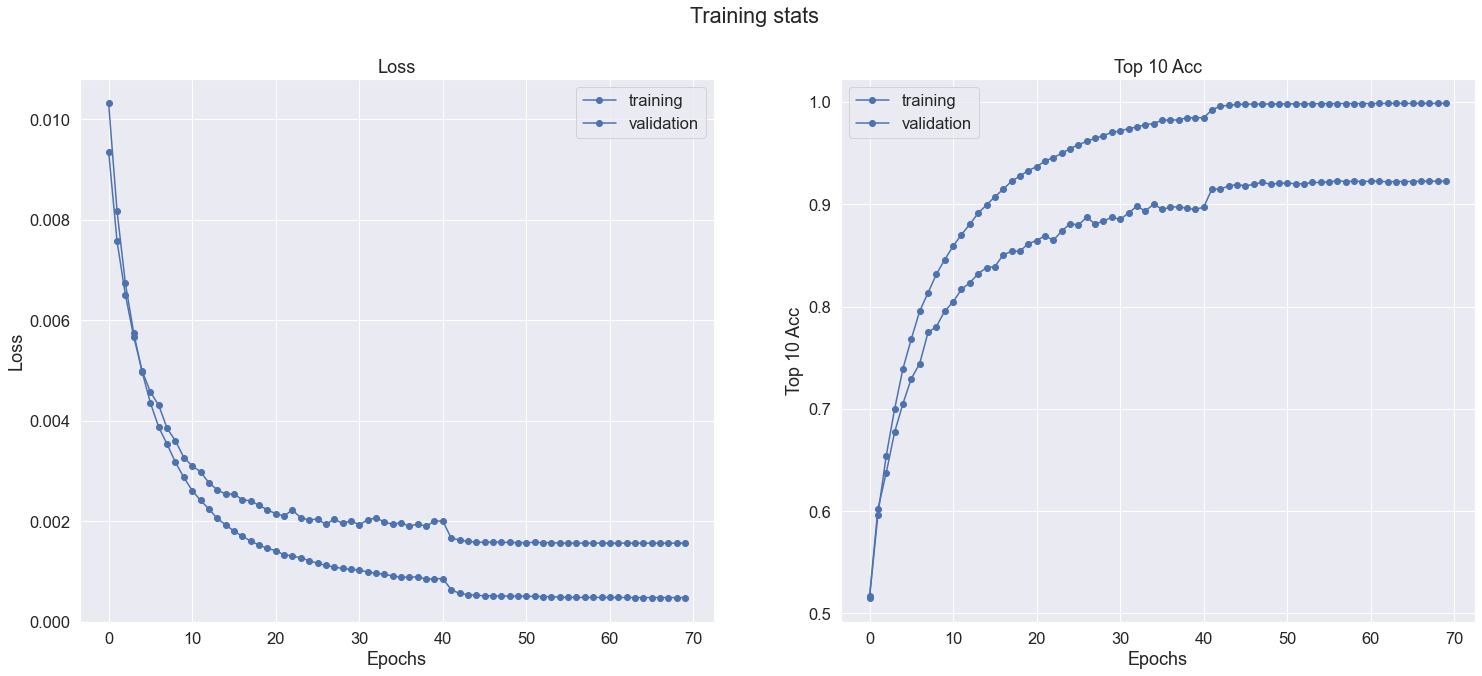

Wall time: 10min 32s


In [23]:
%%time
print('TRAINING...')

training_stats = []

total_steps = 0

optimizer.zero_grad() 

with tqdm(total=epochs,leave=False) as pbar:
  for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()

    #optimizer.zero_grad()

    logits = []
    ground_truth = []
    for step, batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),leave=False):

        optimizer.zero_grad()

        b_labels = batch[1]
        with torch.cuda.amp.autocast(enabled=fp16):
          b_logits = model(batch,device)
        
        loss = criterion(b_logits,b_labels.detach()).cuda()

        scaler.scale(loss).backward()
        total_train_loss += loss.item()
        
        logits.extend(b_logits.detach().numpy())
        ground_truth.extend(np.argmax(b_labels.detach().numpy(),axis=1))    

        scaler.step(optimizer)
        scaler.update()
        total_steps+=1

    y_top10_idx = np.argpartition(logits, -10, axis=1)[:, -10:]
    y_labels = np.argmax(logits,axis=1)

    train_top10 = top10_accuracy_scorer(ground_truth,y_top10_idx)
    train_acc = round(metrics.accuracy_score(ground_truth,y_labels),3)
    avg_train_loss = total_train_loss/len(train_dataloader)

    model.eval()

    total_dev_loss = 0

    logits = []
    ground_truth = []
            
    for step, batch in enumerate(valid_dataloader):

        inputs = batch[0].to(device)
    
        b_labels = batch[1]
        with torch.cuda.amp.autocast(enabled=fp16):
          with torch.no_grad():
            b_logits = model(batch,device)
        loss = criterion(b_logits,b_labels.detach()).cuda()

        loss = criterion(b_logits,b_labels.detach()).cuda()

        scaler.scale(loss)
        total_dev_loss += loss.item()

        logits.extend(b_logits.float().detach().numpy())
        ground_truth.extend(np.argmax(b_labels.detach().numpy(),axis=1))


    y_top10_idx = np.argpartition(logits, -10, axis=1)[:, -10:]
    y_labels = np.argmax(logits,axis=1)

    test_top10 = top10_accuracy_scorer(ground_truth,y_top10_idx)
    test_acc = round(metrics.accuracy_score(ground_truth,y_labels),3)
    avg_dev_loss = total_dev_loss/len(valid_dataloader)

    scheduler.step(test_top10)
 
    training_stats.append(
        {
            'train_loss': avg_train_loss,
            'dev_loss': avg_dev_loss,
            'train_acc': train_acc,
            'train_top10':train_top10,
            'dev_acc': test_acc,
            'dev_top10': test_top10
        }
      )
    
    torch.save(model,folder+str(epoch_i)+'.ckpt')
    
    pbar.update(1)

    print('\nEpoch: ',epoch_i,' train_loss ',avg_train_loss,
            ' dev_loss ',avg_dev_loss,
            ' train acc ',train_acc,
            ' train_top10 ',train_top10,
            ' dev_acc ',test_acc,
            ' dev_top10 ', test_top10
          )

# Show training results
col_names = ['train_loss','train_acc','train_top10','dev_loss', 'dev_acc','dev_top10']
training_stats = pd.DataFrame(training_stats,columns=col_names)
make_plot(training_stats)

## INFERENCE AND SUBMISSION

In [21]:
# Load model
model = torch.load('../artifacts/69.ckpt').to(device)
model

TokeNet(
  (cls): Linear(in_features=2540, out_features=1314, bias=True)
)

In [22]:
# Make inference over test data
model.eval()

logits = []
           
for step, batch in enumerate(test_dataloader):
    
    with torch.cuda.amp.autocast(enabled=fp16):
        with torch.no_grad():
            b_logits = model(batch,device)
            logits.extend(b_logits.float())

In [23]:
# Convert logits to probabilities
probas = nn.Softmax(dim=1)(torch.stack(logits)).detach().numpy()
probas.shape

(18816, 1314)

In [24]:
# Make submission, asserting that the format is fine
submission_format = pd.read_csv('../data/raw/submission_format.csv', index_col='sequence_id')
assert submission_format.shape == probas.shape
assert (labs == submission_format.columns).all()

In [25]:
my_submission = pd.DataFrame(data=probas, 
                             columns=labs, 
                             index=submission_format.index)

In [26]:
my_submission.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,
E0VFT,1.507064e-26,1.135527e-12,2.307681e-24,9.993977e-18,2.167192e-13,5.759801e-20,1.063853e-17,4.218995e-12,5.565809e-14,1.331983e-29,...,5.958700e-15,1.572762e-28,1.995915e-15,1.425564e-19,1.741388e-13,5.456527e-16,1.196837e-13,2.091701e-15,4.475036e-36,5.341344e-15
TTRK5,5.013319e-21,8.872954e-17,8.899707e-23,1.251287e-16,1.173707e-13,4.324332e-17,7.129619e-17,1.617816e-09,5.810273e-14,5.772089e-32,...,1.566170e-17,8.443807e-22,8.370491e-15,2.989087e-18,1.407700e-12,1.108910e-14,3.141004e-13,1.452385e-12,9.625871e-34,5.696191e-16
2Z7FZ,7.140531e-24,3.875195e-10,2.113916e-27,5.777329e-17,1.470858e-10,3.599071e-08,1.015164e-08,9.428297e-07,2.259032e-14,2.078659e-35,...,1.586089e-15,1.200853e-21,2.242790e-10,6.968790e-17,1.541446e-10,1.405617e-13,4.747988e-10,1.233389e-12,7.255234e-35,1.240452e-13
VJI6E,9.133081e-09,1.867238e-06,6.049303e-08,9.707491e-06,2.659466e-05,4.469864e-07,5.433973e-07,1.057862e-05,1.178356e-02,3.521117e-09,...,3.922181e-06,3.690099e-09,1.616442e-04,1.382616e-04,1.117325e-05,3.302807e-06,2.454438e-06,7.723232e-07,2.420026e-09,2.966848e-05
721FI,7.632481e-12,9.981542e-07,4.474809e-17,4.505811e-10,1.595046e-06,7.514151e-12,9.298266e-11,1.607556e-06,3.026865e-06,3.758008e-22,...,4.892472e-08,1.392072e-15,1.468986e-08,9.954633e-12,9.430487e-08,1.648157e-09,8.240267e-09,6.380986e-08,4.168490e-21,3.158817e-08


In [27]:
# Save submission
my_submission.to_csv('../submissions/submission.csv')

## INTERPRETABILITY

Let's predict for one sequence and ask: Why the model has predicted this lab? In what features has it paid attention?

Pros
- How the model as predicted this lab? Easy, **a simple matrix multiplication**. With complex models gets more complicated but there are methods like SHAP.
- The features the model bases his predictions are all **human readable**.

In [54]:
weights = model.cls.weight.data

In [33]:
inputs_sequence_to_predict = test_dataset[0]
id_lab_predicted = np.argmax(probas[0])
lab_predicted = labs[id_lab_predicted]
lab_weights = weights[id_lab_predicted].cpu()

print('Lab id: ', id_lab_predicted)
print('Lab: ',lab_predicted)

Lab id:  278
Lab:  7GWW4637


In [52]:
# Get TOP K most activated features
activations = lab_weights * inputs_sequence_to_predict[0]
top_features = torch.topk(activations,k=5,dim=0,largest=True,sorted=True)

In [53]:
for feature_indice in top_features.indices.detach().numpy():
    if feature_indice <= 40:
        print('Tabular: ',train.columns.values[feature_indice])
    else:
        print('Subsequence: ',tokenizer.decode([feature_indice]))

Subsequence:  TTCAGCTCC
Subsequence:  GAGTT
Subsequence:  TAAAGC
Tabular:  species_zebrafish
Subsequence:  CGCCTT


With this, now you can compare it with your train data in multiple ways and ask questions like:

- Does this subsequences appear in other sequences from the same laboratory?
- What subsequences makes the model decide that this sequence is from this laboratory and not this other sequence?
- ...